#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [67]:
#Загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [68]:
#Загрузим датасеты и установим индекс датафрейма
try:
    data=pd.read_csv('C:/Users/ARTEM/Desktop/Project_DS/Временные ряды/taxi.csv',index_col=[0],parse_dates=[0])    
except:
    data=pd.read_csv('/datasets/taxi.csv')
    

In [69]:
#Взглянем на первые 5 строк
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [70]:
#Посмотрим под этим углом
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [71]:
#Нужно будет изменить столбец datetime с object на datetime
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [72]:
#Чтобы работать с временными рядами, необходимо проверить, в хронологическом ли порядке расположены дата и время
print(data.index.is_monotonic)

True


In [73]:
#Проверим на наличие пропусков
data.isna().sum()

num_orders    0
dtype: int64

### Вывод:
- Установлен индекс датафрейма в качестве даты
- Рассматриваемый период с 01.03.2018 по 31.08.2018
- Даты расположены в хронологическом порядке
- Пропуски отсутствуют

## Анализ

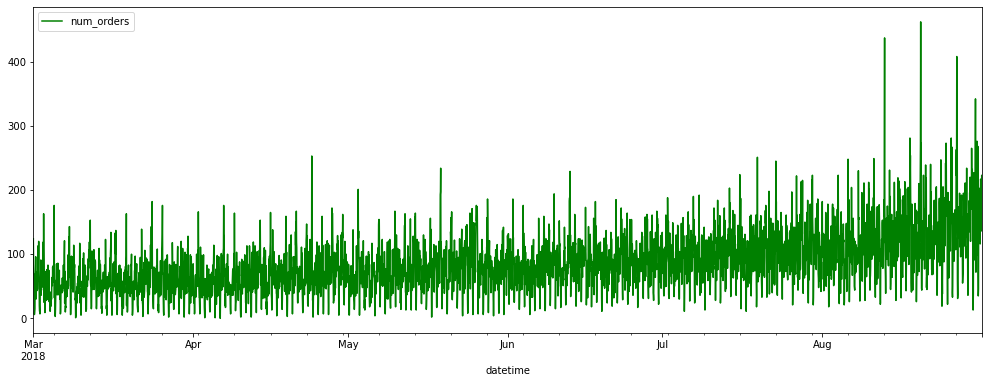

In [74]:
#Сделаем ресеплинг по одному часу
data = data.resample('1H').sum()
figsize = (17, 6)
color='green'
data.plot(figsize=figsize,color=color)
plt.show()


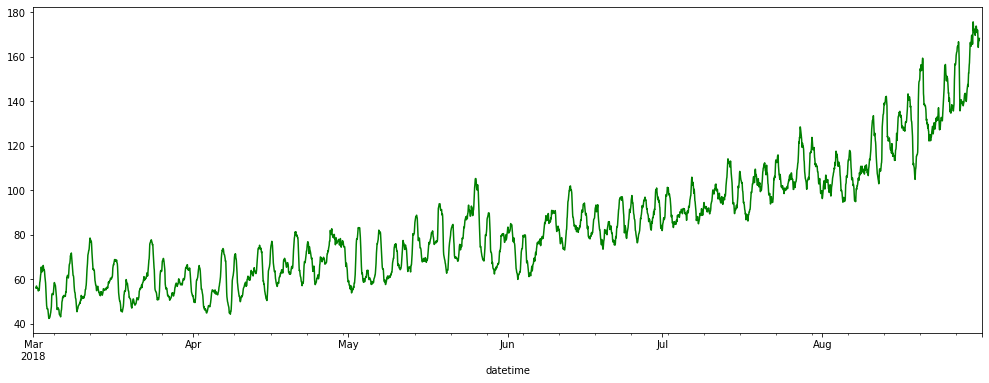

In [75]:
#Разложим временной ряд на три составляющие: тренд
decomposed_data = seasonal_decompose(data)
decomposed_data.trend.plot(figsize=figsize,color=color)
plt.show()   

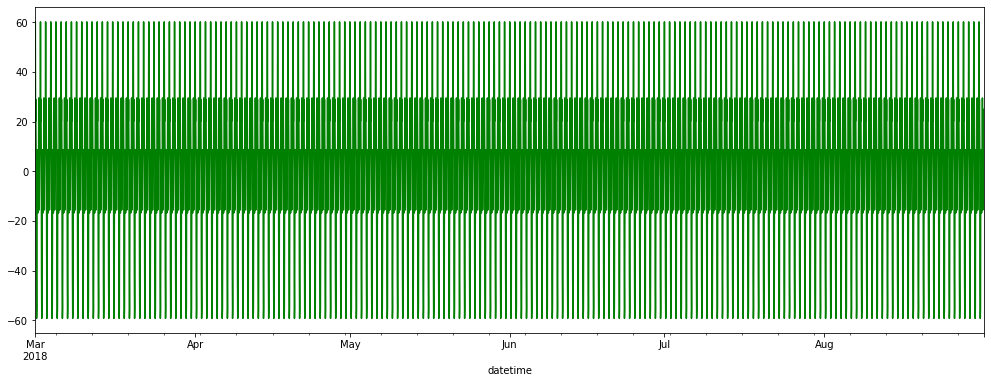

In [76]:
#Разложим временной ряд на три составляющие: сезонность
decomposed_data.seasonal.plot(figsize=figsize,color=color)
plt.show()  

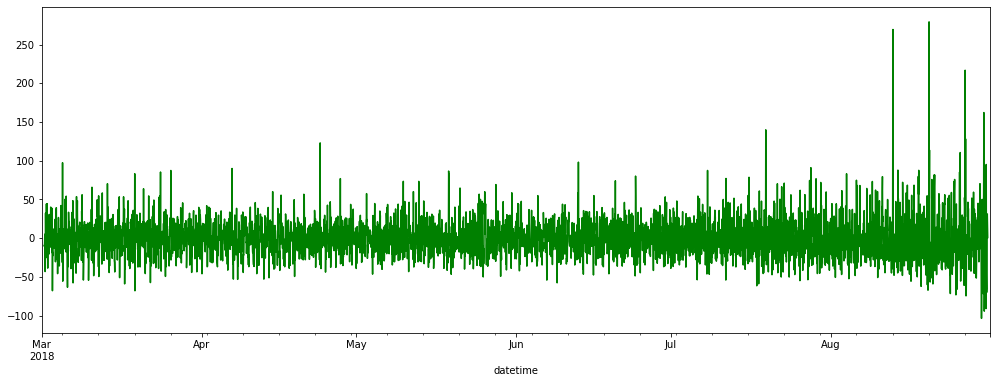

In [77]:
#Разложим временной ряд на три составляющие: остаток
decomposed_data.resid.plot(figsize=figsize,color=color)
plt.show()  

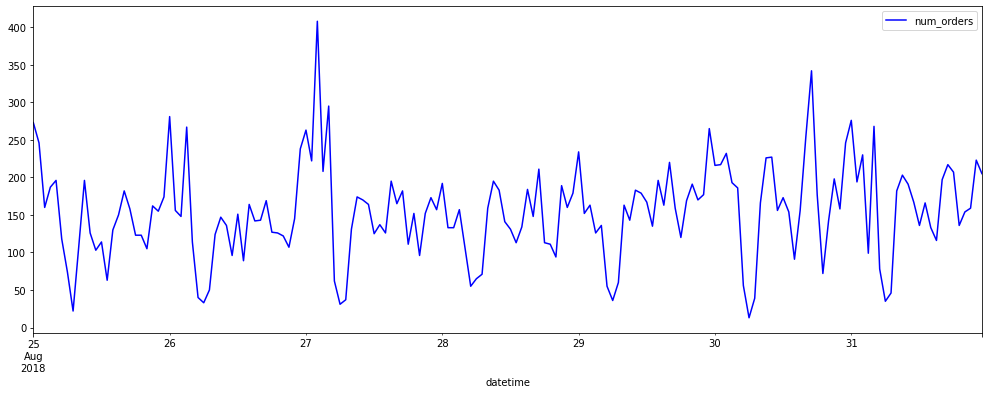

In [78]:
#Проанализируем последнюю неделю данных, т.к. пока лишь мы можем сказать, что в целом тренд направлен на увеличение кол-во заказов
color='blue'
data_last_week=data['2018-08-25':'2018-08-31']
data_last_week.plot(figsize=figsize,color=color)
plt.show()

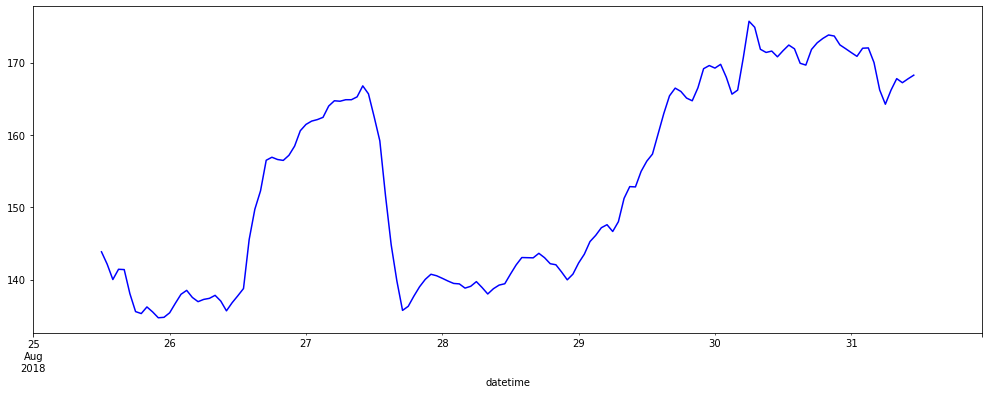

In [79]:
#Разложим временной ряд на три составляющие:тренд
decomposed_data = seasonal_decompose(data_last_week)
decomposed_data.trend.plot(figsize=figsize,color=color)
plt.show()   

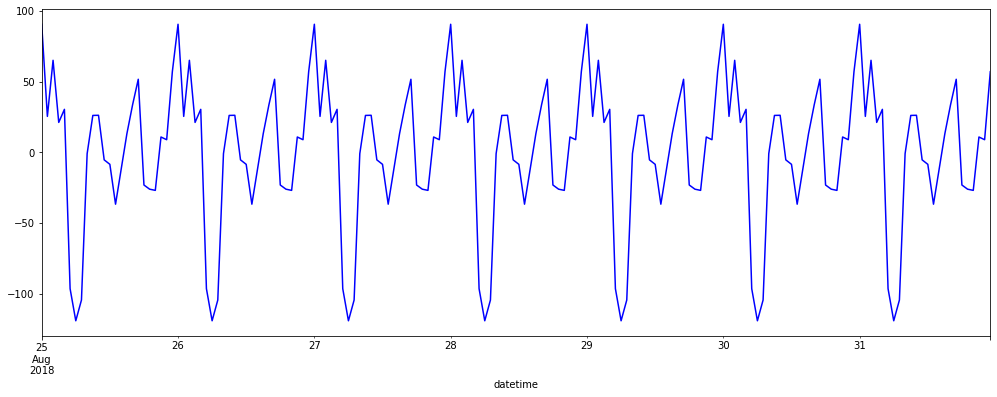

In [80]:
#Разложим временной ряд на три составляющие:сезонносит
decomposed_data.seasonal.plot(figsize=figsize,color=color)
plt.show()   

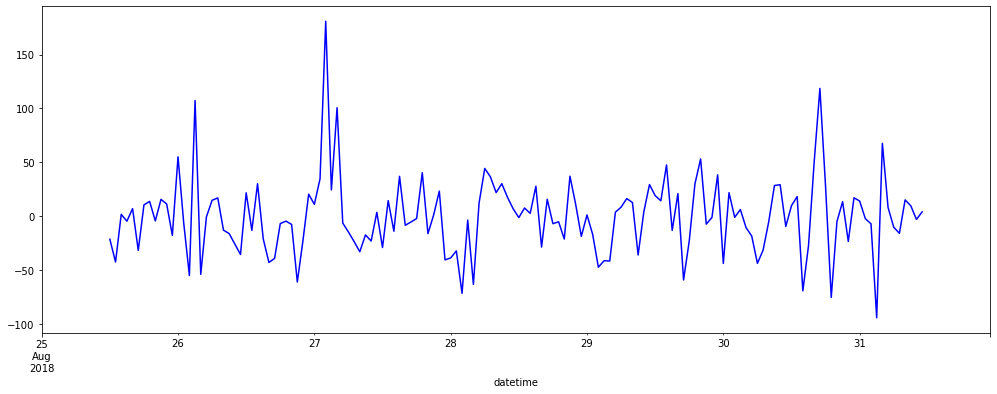

In [81]:
decomposed_data.resid.plot(figsize=figsize,color=color)
plt.show()   

### Вывод:
- Количество заказов  целом растет
- Количество заказов в утренние часы меньше, а к вечеру растет
- Тренд меняется по времени

## Обучение

In [82]:
#Создадим функцию для признаков

def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

In [83]:
#Возьмем эти параметры

make_features(data, 24, 150)

In [84]:
#Удалим пропуски
data=data.dropna()

In [85]:
#Взглянем на данные
data.head(5)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-07 06:00:00,19,2,6,10.0,73.0,66.0,24.0,121.0,100.0,47.0,...,40.0,42.0,41.0,48.0,51.0,52.0,25.0,10.0,7.0,53.753333
2018-03-07 07:00:00,17,2,7,19.0,10.0,73.0,66.0,24.0,121.0,100.0,...,63.0,40.0,42.0,41.0,48.0,51.0,52.0,25.0,10.0,53.053333
2018-03-07 08:00:00,38,2,8,17.0,19.0,10.0,73.0,66.0,24.0,121.0,...,42.0,63.0,40.0,42.0,41.0,48.0,51.0,52.0,25.0,52.600000
2018-03-07 09:00:00,50,2,9,38.0,17.0,19.0,10.0,73.0,66.0,24.0,...,52.0,42.0,63.0,40.0,42.0,41.0,48.0,51.0,52.0,52.380000
2018-03-07 10:00:00,34,2,10,50.0,38.0,17.0,19.0,10.0,73.0,66.0,...,51.0,52.0,42.0,63.0,40.0,42.0,41.0,48.0,51.0,52.273333


In [86]:
#Поделим на целевые и признаки
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [87]:
#Проверка
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3839, 27)
(427, 27)
(3839,)
(427,)


In [88]:
#Случайный лес
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [89]:
rmse_score = make_scorer(rmse, greater_is_better = False)

In [90]:
#Почему то в тренажере и теории не написано про TimeSeries Split. Я прочитал по дефолту берут 5 на сколько это верно?
model = RandomForestRegressor(random_state=12345)
param_search = { 
    'n_estimators': [3, 10, 30],
    'max_depth' : [i for i in range(1,10)]
}
tscv = TimeSeriesSplit(n_splits=5) 
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(features_train, target_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [91]:
best_model

RandomForestRegressor(max_depth=9, n_estimators=30, random_state=12345)

In [92]:
print('RMSE',abs(best_score))

RMSE 25.82565127818728


In [93]:
#Линейная регрессия
model_lr = LogisticRegression(random_state=12345)
scores = cross_val_score(LinearRegression(),features_train,target_train,scoring=rmse_score,cv=tscv)
print('RMSE',scores.mean()*(-1))




RMSE 27.506509651581418


In [94]:
#Дерево решений
model_dt= DecisionTreeRegressor(random_state=12345)
param_search = {
    "max_depth" : [i for i in range(1,10)],
    "min_samples_leaf" : [i for i in range(1,10)]
}
tscv = TimeSeriesSplit(n_splits=5) 
gsearch = GridSearchCV(estimator=model_dt, param_grid = param_search, scoring=rmse_score, cv=tscv)
dt_model = gsearch.fit(features_train,target_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [95]:
best_model

DecisionTreeRegressor(max_depth=7, min_samples_leaf=9, random_state=12345)

In [96]:
abs(best_score)

29.496709485648644

In [97]:
result = {'Модель': ['Случайный лес', 'Линейная регрессия', 'Дерево решений'],
                  'RMSE': [25.8, 27.5, 29.5]
                 }
result=pd.DataFrame(result)


result.style.hide_index()

C:\Users\ARTEM\AppData\Local\Temp\ipykernel_36276\1099864992.py:7: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  result.style.hide_index()


Модель,RMSE
Случайный лес,25.800000
Линейная регрессия,27.500000
Дерево решений,29.500000


### Вывод:
Наиболее эффективной оказался случайный лес

## Тестирование

In [98]:
#Проверим на тесте
model=RandomForestRegressor(max_depth=9, n_estimators=30, random_state=12345)
model=model.fit(features_train, target_train)
predict=model.predict(features_test)
print('RMSE на тестовой',rmse(predict,target_test))

RMSE на тестовой 44.373848755477546


### Вывод:
Наибольшую эффективность показала модель случайного леса, на тестовой выборке получили значение RMSE менее 48